In [ ]:
import ast
import json, pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("archive/clean_IMDB3.csv")

In [ ]:
tokens = df["clean_review"].apply(ast.literal_eval)
texts = tokens.apply(lambda t: " ".join(t)).tolist()

In [4]:
y = df["sentiment"].map({"negative":0, "positive":1}).astype(int).values

In [5]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
max_words = 20000 
max_len   = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

In [7]:
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

In [8]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len)

In [ ]:
embedding_dim = 100
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

c:\Users\djibr\miniconda3\envs\terEnv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5)
]

In [12]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.7787 - loss: 0.4545 - val_accuracy: 0.8576 - val_loss: 0.3362 - learning_rate: 0.0010
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8833 - loss: 0.2834 - val_accuracy: 0.8665 - val_loss: 0.3066 - learning_rate: 0.0010
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9338 - loss: 0.1809 - val_accuracy: 0.8660 - val_loss: 0.3318 - learning_rate: 0.0010


In [13]:
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Accuracy (evaluate): {acc:.4f}")

Accuracy (evaluate): 0.8669


In [14]:
y_prob = model.predict(X_test_pad, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

In [15]:
print("Accuracy (sklearn):", accuracy_score(y_test, y_pred))
print("F1 (weighted):     ", f1_score(y_test, y_pred, average="weighted"))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=["negative","positive"], zero_division=0))

Accuracy (sklearn): 0.8669
F1 (weighted):      0.8668771547885331

Rapport de classification :
              precision    recall  f1-score   support

    negative       0.88      0.85      0.87      5000
    positive       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



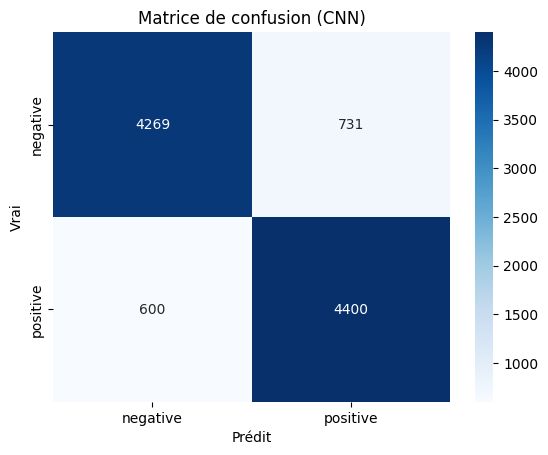

In [16]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.title("Matrice de confusion (CNN)")
plt.xlabel("Prédit"); plt.ylabel("Vrai")
plt.show()

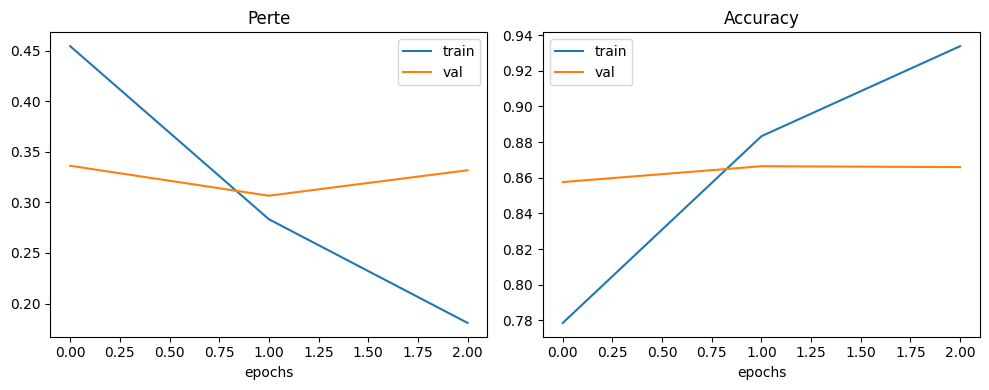

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history.get("loss", []), label="train")
plt.plot(history.history.get("val_loss", []), label="val")
plt.title("Perte"); plt.xlabel("epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get("accuracy", []), label="train")
plt.plot(history.history.get("val_accuracy", []), label="val")
plt.title("Accuracy"); plt.xlabel("epochs"); plt.legend()
plt.tight_layout()
plt.show()

In [18]:
model.save("modelDL/CNN/cnnModelV1.h5")
with open("modelDL/CNN/cnntokenizerV1.pkl","wb") as f:
    pickle.dump(tokenizer, f)
with open("modelDL/CNN/cnnconfigV1.json","w") as f:
    json.dump({"max_len": int(max_len)}, f)
with open("modelDL/CNN/cnnclass_namesV1.json","w") as f:
    json.dump(["negative","positive"], f)
with open("modelDL/CNN/cnnhistoryV1.json", "w") as f:
    json.dump(history.history, f)

In [ ]:
def predict_one(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len)
    p = float(model.predict(pad, verbose=0).ravel()[0])
    label = "positive" if p >= 0.5 else "negative"
    return label, p

In [20]:
print(predict_one("This movie is awful. Boring and badly acted."))
print(predict_one("I absolutely loved this film! Great story and acting."))

('negative', 0.49724069237709045)
('positive', 0.6986284255981445)
